In [115]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
from go_learning_helpers import *
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
import seaborn as sns

## this suppresses the warnings encountered during normal use of Matthew's Corr Coeff from sklearn
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Let's generate a few go_annotation datasets. 

We'll use the original annotations (post-stopwords) binarized, a single-occurence-filtered-out annotations binarized, and a single-occurence-filtered-out tfidf model.

In [2]:
go_file = '../data/goData/kinase_go_processes.csv'
go_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(go_dir+go_file)

# filter out any empty kinases
go_annotations = go_annotations[map(lambda x: len(x) > 0, [x for x in go_annotations])]

# generate binarized go_annotations
go_lab_binner, bin_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

# create a frequency chart for every label in the go_annotations 
# this allows us to screen out labels with only one occurence (to help reduce noise)
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1
texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

# generate binarized go_annotations for the intermediate, filtered go_annotations
filter_go_annotations = pd.Series(texts)
filter_go_annotations.index = go_annotations.index
filter_go_annotations.name = go_annotations.name

# filter out any empty filter_kinases
filter_go_annotations = filter_go_annotations[map(lambda x: len(x) > 0, [x for x in filter_go_annotations])]

freq_go_lab_binner, freq_go_annotations = convert_go_annotations_to_one_hot(filter_go_annotations,
                                                   return_binarizer= True)
        
# create a corpus and dictionary (reference) objects for a tfidf model for the go_annotations
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(doc) for doc in texts]

# create a tfidf series for the go_annotations
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# we have to parse gensim's sparse format back into pd.Series format
hold = []
rej = []
for i in range(len(corpus_tfidf)):
    if(len(corpus_tfidf[i]) > 1):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        rej += [go_annotations.index[i]]
    

tfidf_go_annotations = pd.Series([x for x in sp.vstack(hold).toarray()])
tfidf_go_annotations.index = [x for x in go_annotations.index.tolist() if x not in rej]
tfidf_go_annotations.name = go_annotations.name

# create a dictionary with our datasets
go_data_dict = {'go':bin_go_annotations,'freq':freq_go_annotations,'tfidf':tfidf_go_annotations }

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [3]:
cluster_dir = '../results/'

spinglass_file = 'consensus_spinglass.txt'
spinglass_data_dict = {key:add_cluster_labels(cluster_dir+spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fastgreedy_file = 'fastgreedy_clusters.txt'
fastgreedy_data_dict = {key:add_cluster_labels(cluster_dir+fastgreedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensus_eigenvector.txt'
eigen_data_dict = {key:add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

labelprop_file = 'consensus_label_propagation.txt'
labelprop_dict = {key:add_cluster_labels(cluster_dir+labelprop_file,
                                  val) for key, val in go_data_dict.items()}

walktrap_file = 'consensus_walktrap.txt'
walktrap_dict = {key:add_cluster_labels(cluster_dir+walktrap_file,
                                  val) for key, val in go_data_dict.items()}

louvain_super_file = 'louvain_clusters.txt'
louvain_super_dict = {key:add_cluster_labels(cluster_dir+louvain_super_file,
                                  val) for key, val in go_data_dict.items()}

louvain_sub_file = 'louvain_small_clusters.txt'
louvain_sub_dict = {key:add_cluster_labels(cluster_dir+louvain_sub_file,
                                  val) for key, val in go_data_dict.items()}

infomap_file = 'consensus_infomap.txt'
infomap_dict = {key:add_cluster_labels(cluster_dir+infomap_file,
                                  val) for key, val in go_data_dict.items()}

edge_betweenness_file = 'edge_betweenness_community_clusters.txt'
edge_betweenness_dict = {key:add_cluster_labels(cluster_dir+edge_betweenness_file,
                                  val) for key, val in go_data_dict.items()}

method_list = ['spinglass', 'fastgreedy', 'eigen', 'labelprop', 'walktrap', 'louvain_super', 'louvain_sub', 'infomap', 'edge_between']
method_dicts = [spinglass_data_dict, fastgreedy_data_dict, eigen_data_dict, labelprop_dict, walktrap_dict, louvain_super_dict, louvain_sub_dict, infomap_dict, edge_betweenness_dict]
composite_data_dict = {x:y for x,y in zip(method_list, method_dicts)}

Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  24 kinases due to zero length post-processing
Dropped  0 kinases due

Now, let's import a few linear classifiers

In [4]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear', class_weight='balanced')
cnb = CNB()

classifiers = [svm, cnb]
clf_names = [str(clf.__class__).split('.')[-1][0:-2] for clf in classifiers]

And get the accuracy and MCC scores for our datasets

In [5]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
results_dict = {}

for method in composite_data_dict.keys():
    results_dict[method] = {str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in composite_data_dict[method].items() for clf in classifiers}
    

In [6]:
mean_results = {}
std_results = {}

for method in method_list:
    mean_results[method] = {key:np.mean(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    std_results[method] = {key:np.std(np.vstack(map(np.array, results_dict[method][key])), axis=0) for key in results_dict[method].keys()}
    

In [7]:
for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
    

spinglass | [0.26666667 0.2427959 ]
fastgreedy | [0.7037037  0.62389213]
eigen | [0.66666667 0.23223427]
labelprop | [0.97037037 0.73890975]
walktrap | [0.14814815 0.17103654]
louvain_super | [0.7037037  0.62557889]
louvain_sub | [0.39259259 0.38198415]
infomap | [0.33333333 0.23875031]
edge_between | [0.65185185 0.5053231 ]


In [8]:
for method in method_list:
    print(method+' | '+str(mean_results[method]['ComplementNB']))
    

spinglass | [0.6        0.54311655]
fastgreedy | [0.63703704 0.55499324]
eigen | [0.53333333 0.18639912]
labelprop | [0.78518519 0.36378572]
walktrap | [0.42962963 0.39738883]
louvain_super | [0.7037037  0.63198127]
louvain_sub | [0.59259259 0.55333873]
infomap | [0.54074074 0.49355806]
edge_between | [0.67407407 0.50147602]


In [9]:
# old linear results
'''for method in method_list:
    print(method+' | '+str(mean_results[method]['SVC']))
    '''

"for method in method_list:\n    print(method+' | '+str(mean_results[method]['SVC']))\n    "

In [10]:
mod_table = pd.read_csv('../results/clustering_modularity_results.txt', sep='\t')
mod_table

,fast_greedy,spinglass,eigen,walktrap,label,louvain,small_louvain,infomap,edge_between
0,0.350078,0.338763,0.247766,0.272734,0.017304,0.368041,0.321034,0.281936,0.170605


In [11]:
cluster_descriptions = {}
mod_scores = {}

mod_table = pd.read_csv('../results/clustering_modularity_results.txt', sep='\t')
mod_scores = {x:y for x,y in zip(method_list, mod_table.loc[0].values)}

for method in method_list:
    # grab the cluster list from one of the datatype dictionaries
    cluster_list = composite_data_dict[method]['go']['cluster']
    
    # create a counter to get the count data
    clust_counter = Counter(cluster_list)
    
    # count and number of cluster data
    cluster_counts = list(clust_counter.values())
    n_clust = len(cluster_counts)
    
    # mean and std of cluster size
    size_mean = np.round(np.mean(cluster_counts), 1)
    size_std = np.round(np.std(cluster_counts), 1)
    
    # largest and smallest cluster size
    size_max = np.max(cluster_counts) 
    
    # update size and modularity data
    cluster_descriptions[method] = {'N_clust':n_clust, 'Mean clust size':size_mean, 'Clust size std.':size_std, 'Largest clust size':size_max}
    cluster_descriptions[method].update({'Modularity':np.round(mod_scores[method],3)})
    
    # update learnability
    # clf-specific results
    #cluster_descriptions[method].update({clf_name+' accuracy':np.round(mean_results[method][clf_name],2)[0] for clf_name in clf_names})
    #cluster_descriptions[method].update({clf_name+' MCC':np.round(mean_results[method][clf_name],2)[1] for clf_name in clf_names})
    # composite results
    cluster_descriptions[method].update({'Composite Accuracy':np.round(np.mean([mean_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp Acc std.':np.round(np.mean([std_results[method][clf_name][0] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Composite MCC':np.round(np.mean([mean_results[method][clf_name][1] for clf_name in clf_names]),2)})
    cluster_descriptions[method].update({'Comp MCC std.':np.round(np.mean([std_results[method][clf_name][1] for clf_name in clf_names]),2)})
    
results_df = pd.DataFrame.from_dict(cluster_descriptions, orient='index').sort_values(by='Composite MCC', ascending=False)

results_df.columns = ['No. Clusters', 'Mean size', 'sigma size', 'Largest clust',
       'Mod', 'Comp Acc', 'sigma Comp Acc', 'Comp MCC',
       'sigma Comp MCC']

display(results_df)

,No. Clusters,Mean size,sigma size,Largest clust,Mod,Comp Acc,sigma Comp Acc,Comp MCC,sigma Comp MCC
louvain_super,8,59.1,46.9,151,0.368,0.70,0.0,0.63,0.0
fastgreedy,8,59.1,49.4,169,0.339,0.67,0.0,0.59,0.0
labelprop,15,31.5,110.5,445,0.273,0.88,0.0,0.55,0.0
edge_between,16,29.6,65.2,224,0.171,0.66,0.0,0.50,0.0
louvain_sub,36,13.1,18.1,88,0.321,0.49,0.0,0.47,0.0
spinglass,59,8.0,19.8,125,0.350,0.43,0.0,0.39,0.0
infomap,57,8.3,17.3,128,0.282,0.44,0.0,0.37,0.0
walktrap,162,2.9,7.8,79,0.017,0.29,0.0,0.28,0.0
eigen,11,43.0,94.7,330,0.248,0.60,0.0,0.21,0.0


We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


## Convert pandas.DataFrame to TeX


In [12]:
tex_string = results_df.to_latex()
print(tex_string)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  No. Clusters &  Mean size &  sigma size &  Largest clust &    Mod &  Comp Acc &  sigma Comp Acc &  Comp MCC &  sigma Comp MCC \\
\midrule
louvain\_super &             8 &       59.1 &        46.9 &            151 &  0.368 &      0.70 &             0.0 &      0.63 &             0.0 \\
fastgreedy    &             8 &       59.1 &        49.4 &            169 &  0.339 &      0.67 &             0.0 &      0.59 &             0.0 \\
labelprop     &            15 &       31.5 &       110.5 &            445 &  0.273 &      0.88 &             0.0 &      0.55 &             0.0 \\
edge\_between  &            16 &       29.6 &        65.2 &            224 &  0.171 &      0.66 &             0.0 &      0.50 &             0.0 \\
louvain\_sub   &            36 &       13.1 &        18.1 &             88 &  0.321 &      0.49 &             0.0 &      0.47 &             0.0 \\
spinglass     &            59 &        8.0 &        19.8 &            125 &  0.350 &  

## Generate Intra-Supercluster Analysis of Louvain Subclusters


In [13]:
louvain_combined_dict = {key:louvain_super_dict[key].drop('GO Labels', axis=1).merge(louvain_sub_dict[key], on='names', how='left', suffixes = ['_super', '_sub'])
                         for key, val in go_data_dict.items()}


In [14]:
# this is a map of the subclusters in each supercluster
super_sub_dict = louvain_combined_dict['go'].groupby('cluster_super')['cluster_sub'].agg(set)
display(super_sub_dict)

cluster_super
1                                           {8, 26, 7}
2                                   {4, 9, 10, 20, 21}
3                                             {11, 12}
4    {32, 1, 34, 36, 6, 13, 14, 15, 16, 17, 23, 24,...
5                           {35, 3, 5, 18, 25, 29, 31}
6                                                 {19}
7                                          {33, 2, 22}
8                                                 {30}
Name: cluster_sub, dtype: object

In [15]:
louvain_combined_dict.keys()

dict_keys(['go', 'freq', 'tfidf'])

In [16]:
validation_kwargs = {'n_run':5, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
intra_results_dict = {}

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            intra_results_dict[sup_] = {str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf in classifiers}


In [17]:
validation_kwargs = {'n_run':5, 'metrics':['confusion'], 'parallel':None, 'test_size':0.3}
conf_intra_results_dict = {}

# add linear unbalanced svc to the classifiers for visualization
classifiers_ext = {str(clf.__class__).split('.')[-1][0:-2]:clf for clf in classifiers}
unbal_svm = SVC(kernel='linear')
classifiers_ext['unbalSVM'] = unbal_svm 

# iterate over superclusters
for sup_ in super_sub_dict.keys():
    # proceed if more than one subcluster in each supercluster
    if len(super_sub_dict[sup_]) > 1:
        for sub_ in super_sub_dict[sup_]:
            conf_intra_results_dict[sup_] = {clf_key:validate_learnability(dat_df=val[val.cluster_super==sup_], clf=clf, Y_col_name='cluster_sub', **validation_kwargs) for key, val in louvain_combined_dict.items() for clf_key, clf in classifiers_ext.items()}


In [18]:
## normalize the heatmap by row
for sup_ in conf_intra_results_dict.keys():
    for learning_algo in conf_intra_results_dict[sup_].keys():
        # aggregate into average confusion matrix -- not integral do to random sampling size differences
        composite_score = np.mean(conf_intra_results_dict[sup_][learning_algo], axis=0)
        row_sums = np.sum(composite_score, axis=1)
        # normalize
        for i in range(composite_score.shape[0]):
            # add 1 for stability
            composite_score[i,:] = composite_score[i,:] / (1 if row_sums[i] == 0 else row_sums[i])
            
        conf_intra_results_dict[sup_][learning_algo] = composite_score

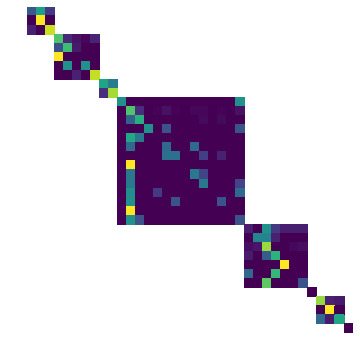

In [19]:
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)
intra_heatmap_matrix

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,6))
ax.axis('off')
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, ax=ax, square=True, cbar=False)

plt.show()

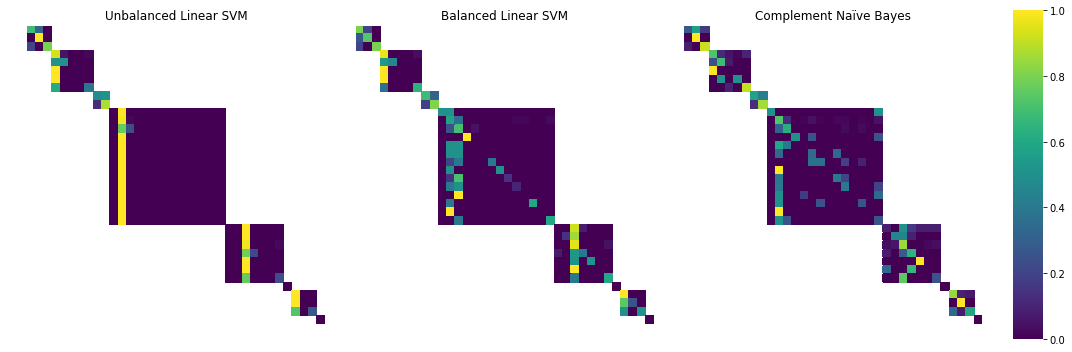

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios':[10,10,10,1]})
for ax in axes[:3]:
    ax.axis('off')

## put complementNB on the right    
intra_heatmap_matrix = np.zeros((len(set(louvain_combined_dict['go'].cluster_sub)),len(set(louvain_combined_dict['go'].cluster_sub))))
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['ComplementNB']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=True, ax=axes[2], cbar_ax=axes[3])


## put balanced SVC in the middle
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['SVC']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    

sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[1])

### put unbalanced svc on the left
intra_heatmap_matrix = np.zeros_like(intra_heatmap_matrix)
intra_heatmap_mask = np.ones_like(intra_heatmap_matrix)

running_index = 0
for sup_ in super_sub_dict.keys():
    num_sub_in_sup = len(super_sub_dict[sup_])
    
    if num_sub_in_sup > 1:
        intra_heatmap_matrix[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = conf_intra_results_dict[sup_]['unbalSVM']
    intra_heatmap_mask[running_index:running_index+num_sub_in_sup, 
                            running_index:running_index+num_sub_in_sup] = 0    
        
    running_index += num_sub_in_sup
    
sns.heatmap(intra_heatmap_matrix, mask=intra_heatmap_mask, cmap=plt.cm.viridis, square=True, cbar=False, ax=axes[0])


## layout and titles
plt.tight_layout()
axes[0].set_title('Unbalanced Linear SVM')
axes[1].set_title('Balanced Linear SVM')
axes[2].set_title('Complement Naïve Bayes')

plt.savefig('intracluster_learnability_comparison.png')

plt.show()

## Generate Learnability Characterizations

In [21]:
louv_X, __, louv_y, __ = get_tts(dat=louvain_super_dict['freq'],test_size=0)

In [22]:
louv_super_characterizers = [SVC(kernel='linear', class_weight='balanced'), CNB()]
for clf in louv_super_characterizers:
    clf.fit(louv_X, louv_y)

In [23]:
feat = freq_go_lab_binner.classes_.tolist()

In [25]:
5 in (7,5)

True

In [67]:
def get_svm_coeffs_for_cluster(svm, cluster_num):
    num_classes = len(svm.classes_)
    combos = list(it.combinations(range(num_classes),2))
    idx_locs = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if cluster_num in y]
    return svm.coef_[idx_locs,:]

In [87]:
# new def
def get_svm_coeffs_for_cluster(svm, cluster_num):
    num_classes = len(svm.classes_)
    combos = list(it.combinations(range(num_classes),2))
    
    # append positive and negative occurrences 
    idx_locs_positive = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if cluster_num == y[0]]
    idx_locs_negative = [x for x, y in enumerate(np.array(list(it.combinations(range(num_classes), 2)))) if cluster_num == y[1]]
    
    return np.vstack([svm.coef_[idx_locs_positive,:], -svm.coef_[idx_locs_negative,:]])

In [99]:
def f_importances(coef, names, top=5, bot=None, plot=True, ax = None):
    ''' returns the most important top (positive) and bot (negative) features
    
    '''
    if bot is None:
        bot = top
    
    importances = coef
    
    # puts smallest first
    importances,names = zip(*sorted(zip(importances,names)))
    # smallest is still first
    most_negative_importances = importances[0:bot]
    most_negative_names = names[0:bot]
    
    most_positive_importances = importances[-top:]
    most_positive_names = names[-top:]
    
    if plot:
        if ax is None:
            plt.yticks(range(bot+top), most_negative_names+most_positive_names)
            plt.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            plt.barh(range(bot), most_negative_importances, align='center', color='blue')
            plt.show()
        else:
            ax.barh(range(bot, bot+top), most_positive_importances, align='center', color='orange')
            ax.barh(range(bot), most_negative_importances, align='center', color='blue')
            ax.set_yticks(range(bot+top))
            ax.set_yticklabels(most_negative_names+most_positive_names)
    else:
        return most_negative_names, most_negative_importances, most_positive_importances, most_positive_names
        

In [123]:
8*7/2

28.0

In [122]:
r = louv_super_characterizers[0]
r.coef_.shape

(28, 1361)

In [50]:
example

array([0, 0, 0, ..., 0, 0, 1])

In [60]:
r.predict(example.reshape(1, len(example)))

array([5])

In [66]:
r.decision_function(example.reshape(1, len(example)))

array([[ 2.98318033,  6.25595872,  4.93351965,  3.97087023,  7.5       ,
        -0.31052399,  1.87690508,  0.79008999]])

In [69]:
r.intercept_

array([-0.25745363,  0.12306682, -0.69267546, -0.17668772,  0.9996244 ,
       -0.05283252,  0.99961015,  0.3816657 , -0.60658777,  0.04876651,
        0.91232949,  0.11261162,  0.92709464, -0.82227912, -0.2312061 ,
        0.9998096 , -0.31665221,  0.99997599,  0.58663911,  0.99029941,
        0.71903727,  0.99965859,  0.90627736,  0.07052241,  0.95453747,
       -0.99999771, -0.02366483,  0.99955711])

In [68]:
np.matmul(get_svm_coeffs_for_cluster(r, 4), example)

array([-0.94863083, -1.27219393, -1.59725388, -3.16038609,  0.14429427,
        1.31550665,  0.04595095])

(n_samples, n_classes * (n_classes - 1) / 2)

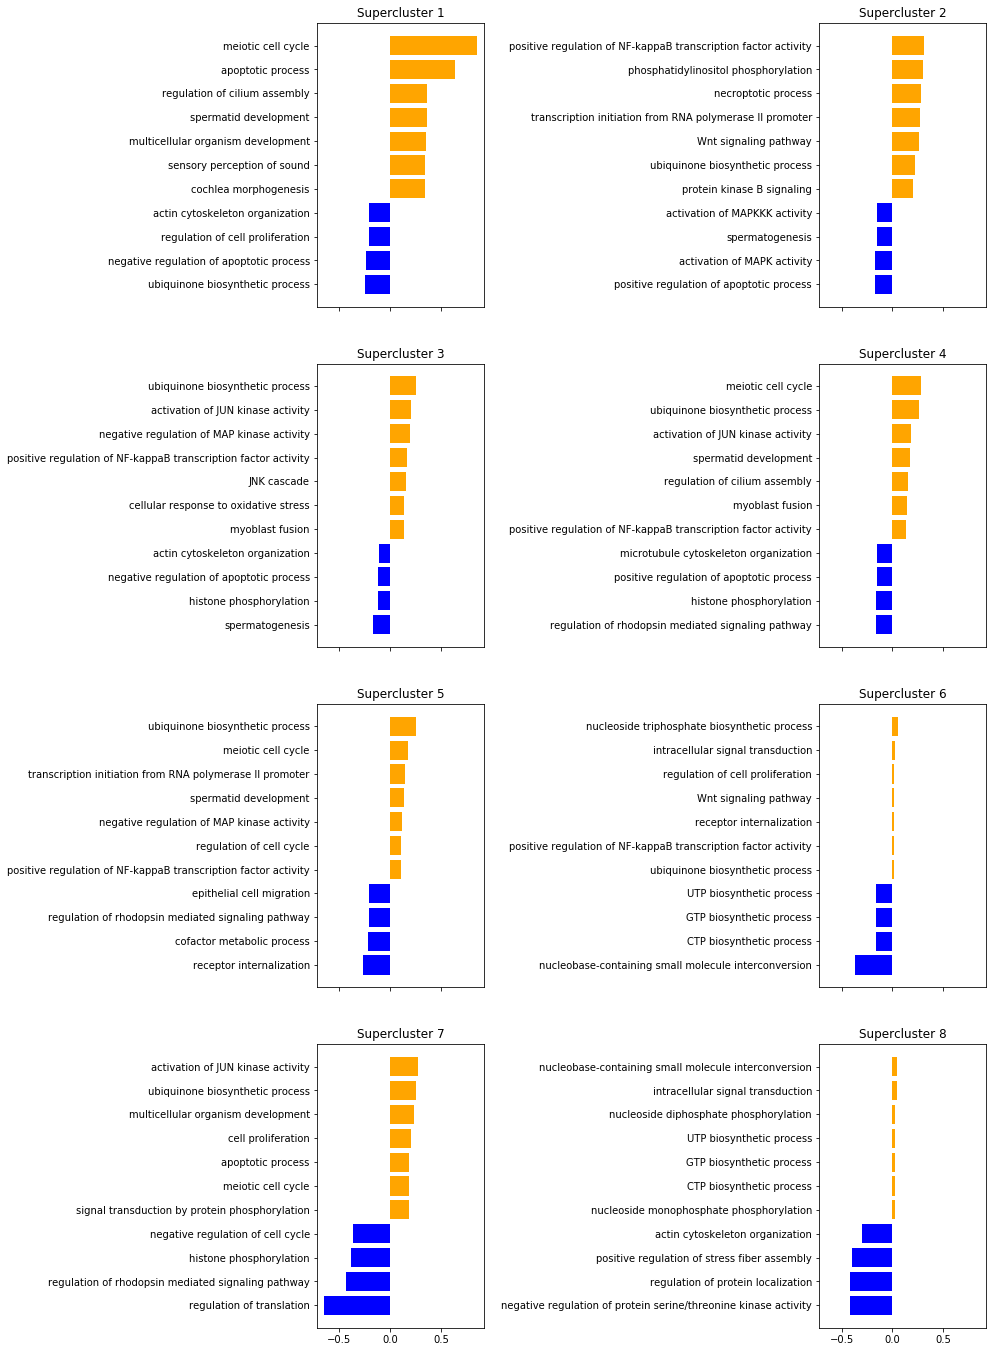

In [124]:
%matplotlib inline
fig, axes = plt.subplots(ncols=2, nrows=4, figsize= (12,24), sharex=True)
plt.subplots_adjust(wspace=2.)
#plt.tight_layout()

for sup_ in super_sub_dict.keys():
    idx = sup_-1
    f_importances(coef=np.mean(get_svm_coeffs_for_cluster(louv_super_characterizers[0], idx), axis=0), names=feat, ax=axes[idx // 2][idx % 2], top=7, bot=4)
    axes[idx // 2][idx % 2].set_title('Supercluster '+str(sup_))

plt.savefig('super_char_orig.pdf')    
plt.show()
#plt.show()


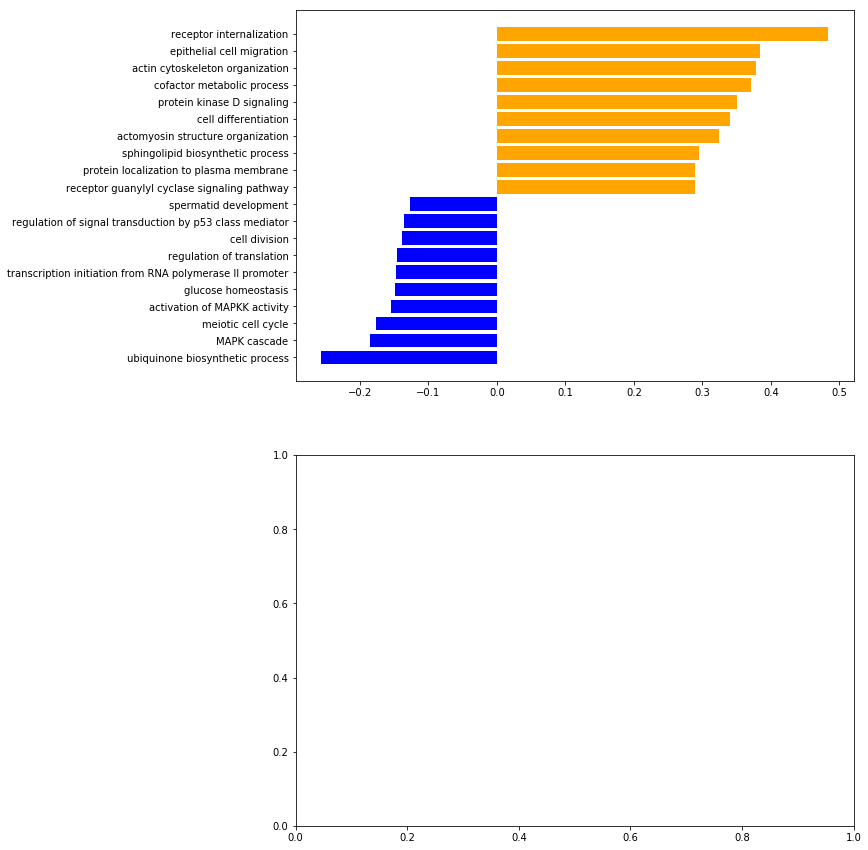

In [106]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,15))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 4), axis=0), names=feat, ax=axes[0], top=10, bot=10)

plt.show()

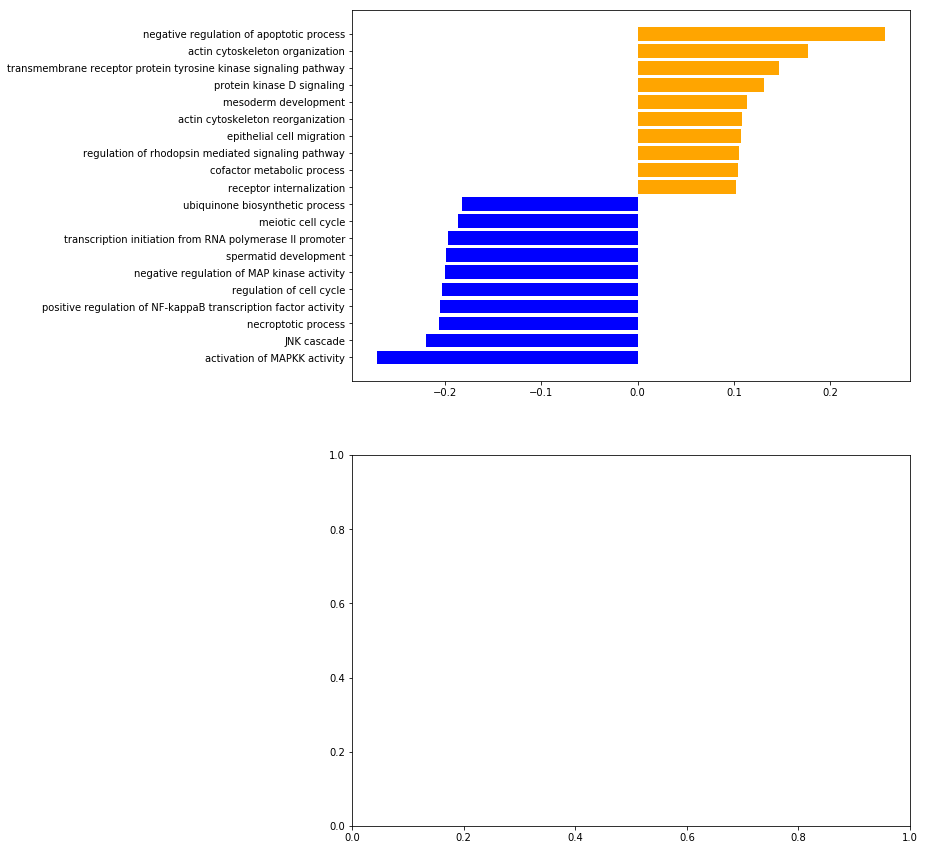

In [78]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,15))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(louv_super_characterizers[0], 4), axis=0), names=feat, ax=axes[0])

plt.show()

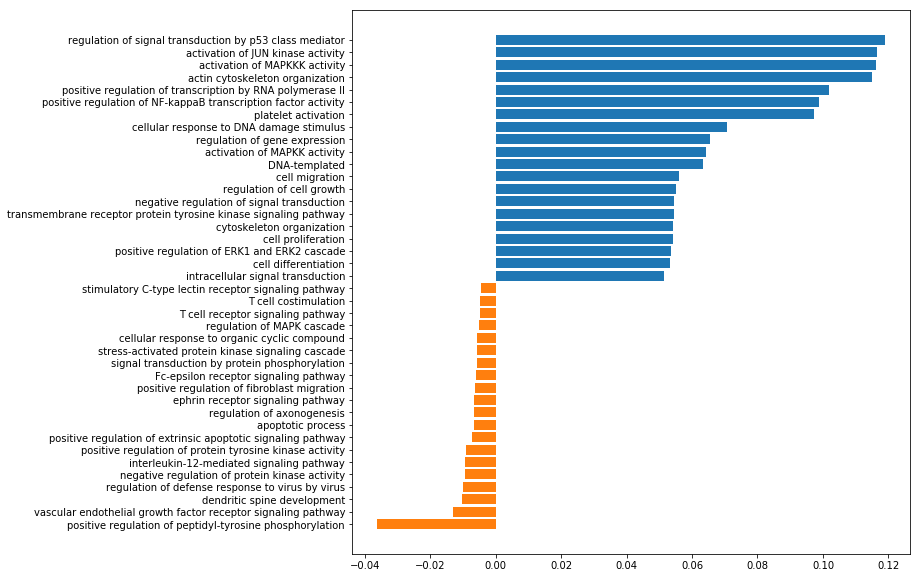

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 1), axis=0), names=feat)

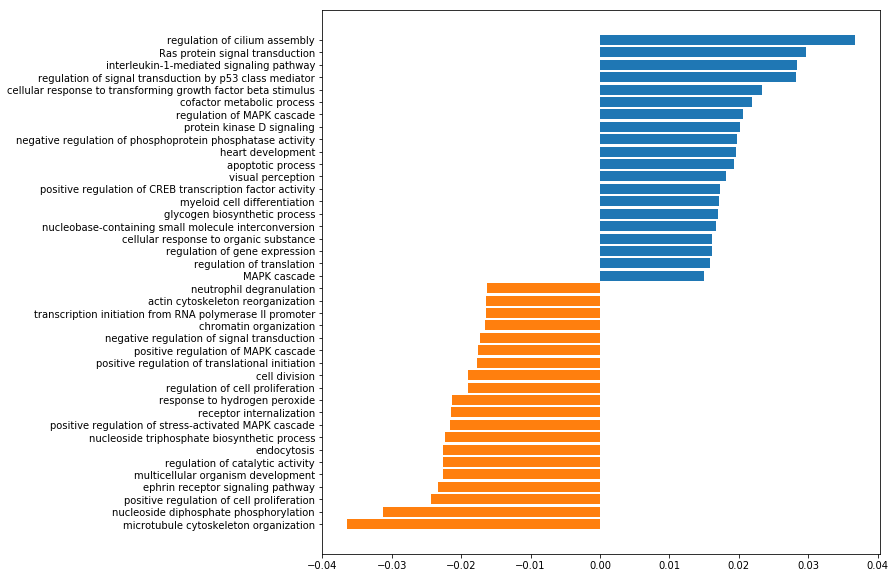

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 7), axis=0), names=feat)

In [92]:
set(filter(lambda x: 'apoptotic' in x, [term for doc in go_annotations for term in doc]))

{'B cell apoptotic process',
 'T cell apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic signaling pathway',
 'apoptotic cell clearance',
 'apoptotic mitochondrial changes',
 'apoptotic nuclear changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'endothelial cell apoptotic process',
 'extrinsic apoptotic signaling pathway',
 'extrinsic apoptotic signaling pathway in absence of ligand',
 'extrinsic apoptotic signaling pathway via death domain receptors',
 'fibroblast growth factor receptor apoptotic signaling pathway',
 'hepatocyte apoptotic process',
 'intrinsic apoptotic signaling pathway',
 'intrinsic apoptotic signaling pathway by p53 class mediator',
 'intrinsic apoptotic signaling pathway in response to DNA damage',
 'intrinsic apoptotic signaling pathway in response to DNA damage by p53 class mediator',
 'intrinsic apoptotic signaling pathw

In [93]:
location = np.where(freq_go_lab_binner.transform(['apoptotic process']))[1][0]
print(location)

95


In [94]:
m_scores = []
for i in range(57):
    try:
        m = np.mean(get_svm_coeffs_for_cluster(svm, i), axis=0)[location]
    except:
        m = 0
        
    m_scores.append(m)

m_scores = np.array(list(filter(lambda x: np.isfinite(x), m_scores)))

In [95]:
low_value = np.percentile(np.array(m_scores), 5)
high_value = np.percentile(np.array(m_scores), 95)

print(low_value)
print(high_value)


-0.041134576199273964
0.02273108124140363


In [96]:
low_clusts = [x for x,y in enumerate(m_scores) if y < low_value]
low_clusts

[33, 40, 56]

In [97]:
high_clusts = [x for x,y in enumerate(m_scores) if y > high_value]
high_clusts

[1, 3, 50]

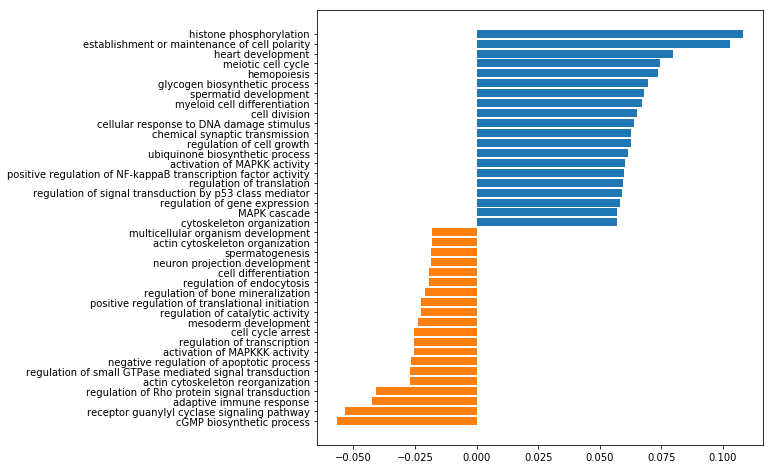

In [98]:
fig, ax = plt.subplots(figsize=(8,8))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 3), axis=0), names=feat)

In [99]:
from scipy.stats import hypergeom
understudied = pd.read_csv('../data/understudied_kinases.csv', header=None)[0].tolist()

def test_understudied(clust, understudied, M):
    N = len(clust)
    
    rv = hypergeom(M, len(understudied), N)
    
    k = sum(map(lambda x: x in understudied, clust))
    
    return rv.pmf(k)

In [107]:
understudied_p_vals = []
spinglass_clusters = composite_data_dict['spinglass']['go']
spinglass_clusters['names'] = spinglass_clusters.index.tolist()
for i in spinglass_clusters['cluster'].unique():
    p_val = test_understudied(spinglass_clusters[spinglass_clusters['cluster']==i]['names'], understudied, M=473)
    understudied_p_vals.append(p_val)

In [108]:
understudied_clusts = []

for loc, p_val in enumerate(understudied_p_vals):
    if(p_val < 0.05):
        understudied_clusts += [loc]
        
print(understudied_clusts)

[1, 2, 5, 11, 12, 23, 41, 44]


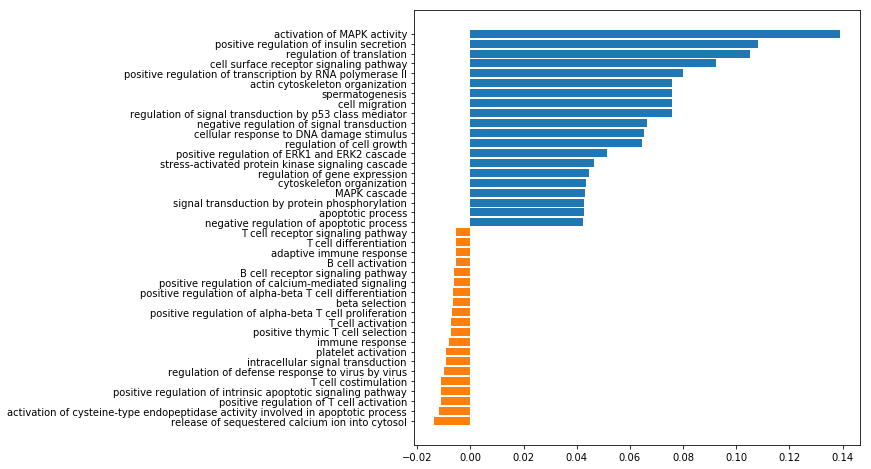

In [109]:
fig, ax = plt.subplots(figsize=(8,8))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 5), axis=0), names=feat)

In [111]:
spinglass_clusters[spinglass_clusters['cluster']==5]

,cluster,GO Labels,names
names,,,
KSYK,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",KSYK
BTK,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",BTK
ZAP70,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",ZAP70
LCK,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",LCK


In [116]:
spin = spinglass_clusters.set_index('names').drop('GO Labels', axis=1)
fast = pd.read_csv(cluster_dir+fastgreedy_file, sep='\t',index_col=0)

Below is the fast_greedy membership of each c_spinglass cluster

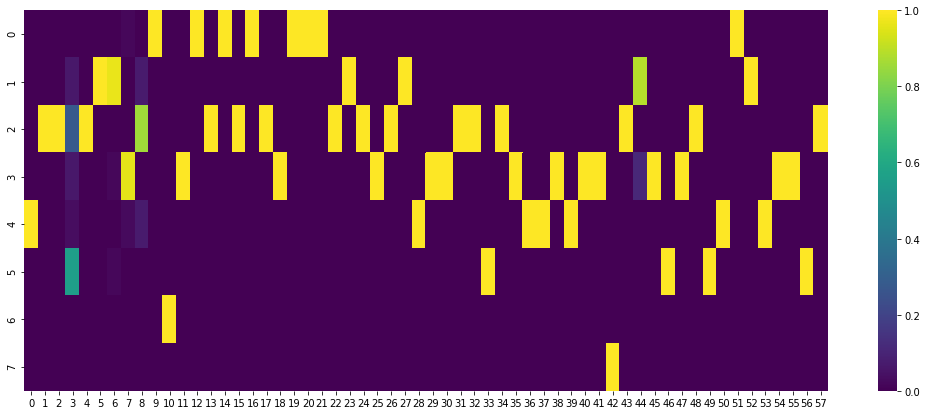

In [117]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(18,7))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Below is the c_spinglass membership of each fast_greedy cluster

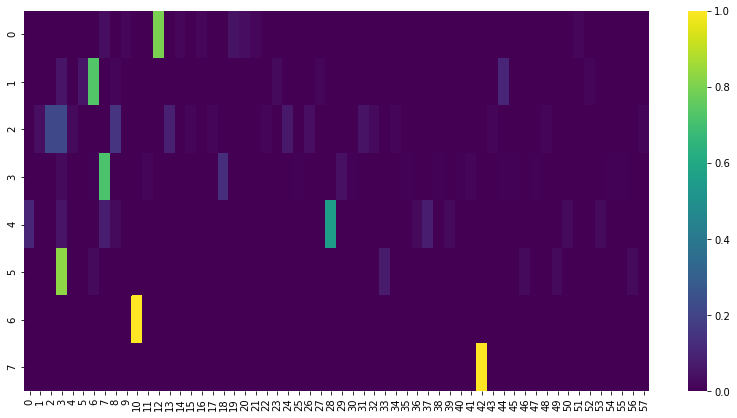

In [118]:
cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)

fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Rand correlation matrix

In [153]:
clusts = {}
for method in method_list:
    cl = composite_data_dict[method]['go']
    clusts[method] = np.squeeze(cl.drop(['GO Labels'], axis=1).values)

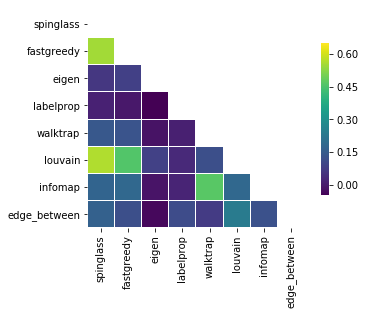

In [177]:
from sklearn.metrics import adjusted_rand_score as rand

rand_corr_matrix = np.zeros((len(clusts), len(clusts)))

for i in range(len(clusts)):
    for j in range(len(clusts)):
        rand_corr_matrix[i,j] = rand(clusts[method_list[i]], clusts[method_list[j]])

mask = np.zeros_like(rand_corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
        
sns.heatmap(rand_corr_matrix,mask=mask,cmap='viridis', square=True, vmax=0.65, cbar_kws={"shrink": .7}, linewidths=0.01, xticklabels=method_list,yticklabels=method_list)